In [146]:
import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable

%matplotlib inline
from matplotlib import pylab as plt

In [290]:
def get_normalized(P1, P2):
    if isinstance(P1, list):
        P1 = torch.FloatTensor(P1)
    if isinstance(P2, list):
        P2 = torch.FloatTensor(P2)
    # 1.中心化
    p1_c, p2_c = P1.mean(dim=0), P2.mean(dim=0)
    print('p1_c:', p1_c)
    print('p2_c:', p2_c)
    P1 -= p1_c
    P2 -= p2_c
    # 2.归一化
    # D1, D2 = [], []
    # for p1, p2 in zip(P1, P2):
    #     D1.append(get_distance(p1, p1_c))
    #     D2.append(get_distance(p2, p2_c))
    # d1 = max(D1)  # -> tensor
    # d2 = max(D2)
    # P1 /= d1
    # P2 /= d2
    return P1, P2

In [142]:
def get_distance(p1, p2):
    if isinstance(p1, list):
        p1 = torch.FloatTensor(p1)
    if isinstance(p2, list):
        p2 = torch.FloatTensor(p2)
    d = torch.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)
    return d

In [244]:
def get_perspective(p, H):
    x, y = p
    src = torch.FloatTensor([x, y, 1]).reshape(3, 1)
    u, v, w = torch.mm(H, src)
    dst = torch.FloatTensor([u/w, v/w])
    return dst

In [221]:
def get_init_H(src, dst):
    a = []
    b = []
    for p1, p2 in zip(src, dst):
        x, y = p1
        u, v = p2    
        ai = torch.zeros(2, 8)
        ai[0, 0:3] = torch.FloatTensor([x, y, 1.])
        ai[1, 3:6] = torch.FloatTensor([x, y, 1.])
        ai[:, 6:8] = torch.FloatTensor([[-u*x, -u*y],
                                        [-v*x, -v*y]])
        bi = torch.FloatTensor([u, v]).reshape(2,1)
        if len(a) == 0:
            a = ai
            b = bi
        else:
            a = torch.cat((a, ai), 0)
            b = torch.cat((b, bi), 0)
    H = np.linalg.solve(a, b)
    H = torch.FloatTensor(np.append(H, 1).reshape(3, 3))
    return H

In [269]:
def ransacMatching(A, B):
    """
    Find the best Perspective Transformation Homography Matrix 'H' using RANSAC Algorithm.
    In RANSAC iterations, each time we recompute least-squares 'H' estimate using all of the inliers.

    # Follow up 1: For step 3, How to do the "test"?
        * Set a threshold 'D2', if the distance between point B.i and the one computed by 'H.dot(A.i)'
          is smaller than 'D2', then (A.i, B.i) will be added to 'new_inliers';
    # Follow up 2: How to decide the "k" mentioned in step 5. Think about it mathematically!
        * Set:
            s = 4  # minimum number of data points required to estimate model parameters;
            p = 0.95: probability having at least picked one set of inliers after iterations;
            e = 0.5: probability that a point is an inlier;
          then the maximum number of iterations 'K' allowed in the algorithm equals to 72 according to:
            1 - p = (1 - e ** s) ** K,
            then K = log(1-p) / log(1 - e ** s).
    -----------------------------------------------------------------------------
    Parameters:
        A & B: list of list.
    """
    assert len(A) == len(B)
    p = 0.95  # probability having at least picked one set of inliers after iterations 
    S = 4  # minimum number of data points required to estimate model parameters
    E = 0.5  # probability that a point is an inlier
    K = 72  # maximum number of iterations allowed in the algorithm
    N = len(A)
    sigma = torch.FloatTensor([get_distance(p1, p2) for p1, p2 in zip(A, B)]).std()
    T = np.sqrt(5.99) * sigma
    dtype = torch.FloatTensor  # torch.float32
    LR = 1e-2
    MOMENTUM = 0.9
    
    # (0) Normalization：---------------------------------------------------------------------------------------------------------------  
    A, B = get_normalized(A, B)  # torch.FloatTensor
    
    # (1) Choose 'S' pair of points randomly in matching points:
    inliers = np.random.choice(range(N), size=S, replace=False).tolist()
    src = [A[_] for _ in inliers]
    dst = [B[_] for _ in inliers]
    
    # (2) Initialize the homography 'H' & loss:
    H = Variable(get_init_H(src, dst), requires_grad=True)
    optimizer = torch.optim.SGD([{'params': H},],
                                lr=LR, momentum=MOMENTUM)
    print(H)
    """ RANSAC Iterations: """
    for i in range(1000):
        optimizer.zero_grad()
        loss = H.sum() * 0
        H_invs = H.inverse()  # TODO: Singular matrix?
        for p1, p2 in zip(src, dst):
            f2 = get_perspective(p1, H)
            f1 = get_perspective(p2, H_invs)
            loss += (get_distance(p2, f2) + get_distance(p1, f1))
        
        # (3) Use this computed homography to test all the other outliers and separated them by using a threshold into two parts:
        new_inliers = []
        outliers =  [_ for _ in range(N) if _ not in inliers]
        for _ in outliers:
            p1 = A[_]
            p2 = B[_]
            f2 = get_perspective(p1, H)
            f1 = get_perspective(p2, H_invs)
            d1 = get_distance(p1, f1)
            d2 = get_distance(p2, f2)
            if d2 <= T and d1 <= T:
                new_inliers.append(_)
                loss += (d1 + d2)
                
        if len(new_inliers) > 0:
            # (4) Get all inliers (new inliers + old inliers) and goto step (2)
            inliers += new_inliers
            src += [A[_] for _ in new_inliers]
            dst += [B[_] for _ in new_inliers]
        else:
            # (5) If there's no changes or we have already repeated step (2)-(4) K times, jump out of the recursion.
            # The final homography matrix 'H' will be the wanted one.
            break
        loss.backward()
        optimizer.step()
    return H.detach().numpy()

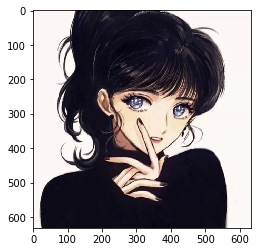

In [188]:
img = plt.imread("20180723165602.jpg")
plt.imshow(img)
plt.show()

In [196]:
h, w, c = img.shape
h, w

(632, 632)

In [159]:
import random

def random_warp(img):
    height, width, channels = img.shape
    random_margin = 60
    # src
    x1, y1 = random.randint(-random_margin, random_margin), random.randint(-random_margin, random_margin)
    x2, y2 = random.randint(width - random_margin - 1, width - 1), random.randint(-random_margin, random_margin)
    x3, y3 = random.randint(width - random_margin - 1, width - 1), random.randint(height - random_margin - 1, height - 1)
    x4, y4 = random.randint(-random_margin, random_margin), random.randint(height - random_margin - 1, height - 1)   
    # dst
    dx1 = random.randint(-random_margin, random_margin)
    dy1 = random.randint(-random_margin, random_margin)
    dx2 = random.randint(width - random_margin - 1, width - 1)
    dy2 = random.randint(-random_margin, random_margin)
    dx3 = random.randint(width - random_margin - 1, width - 1)
    dy3 = random.randint(height - random_margin - 1, height - 1)
    dx4 = random.randint(-random_margin, random_margin)
    dy4 = random.randint(height - random_margin - 1, height - 1)    
    # warp:
    pts1 = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    pts2 = np.float32([[dx1, dy1], [dx2, dy2], [dx3, dy3], [dx4, dy4]])
    M_warp = cv2.getPerspectiveTransform(src=pts1, dst=pts2)
    img_warp = cv2.warpPerspective(src=img, M=M_warp, dsize=(width, height))
    return M_warp, img_warp

[[ 9.27631534e-01  2.80521551e-02  2.42362678e+01]
 [ 3.62832039e-02  9.03138209e-01  1.58827418e+01]
 [ 8.24825843e-06 -5.04762143e-05  1.00000000e+00]]


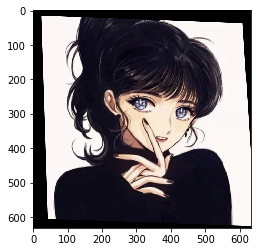

In [194]:
cv2_img = cv2.imread("20180723165602.jpg")
H, cv2_img_warp = random_warp(cv2_img)
print(H)
img_warp = cv2.cvtColor(cv2_img_warp, cv2.COLOR_BGR2RGB)
plt.imshow(img_warp)
plt.show()

In [294]:
A = []
B = []
for i in range(15):
    x = random.randint(0, w-1) * 1.
    y = random.randint(0, h-1) * 1.
    A.append([x, y])
    src = np.array([x, y, 1]).reshape(3,)
    u, v, t = H.dot(src)
    B.append([u/t, v/t])

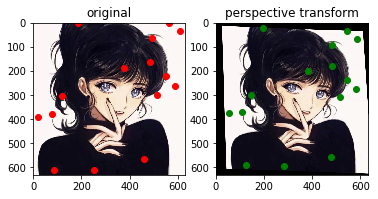

In [295]:
plt.subplot(121)
plt.title("original")
for p in A:
    x, y = p
    plt.scatter(x, y, c='r')
plt.imshow(img)

plt.subplot(122)
for p in B:
    u, v = p
    plt.scatter(u, v, c='g')
plt.title("perspective transform")
plt.imshow(img_warp)

In [296]:
H_hat = ransacMatching(A, B)

p1_c: tensor([358.7333, 272.9333])
p2_c: tensor([367.4850, 280.4637])
tensor([[ 9.3471e-01,  4.7111e-02,  1.1680e+00],
        [ 3.4341e-02,  9.2733e-01, -2.0567e+00],
        [ 8.3415e-06, -5.1025e-05,  1.0000e+00]], requires_grad=True)


In [297]:
H

array([[ 9.27631534e-01,  2.80521551e-02,  2.42362678e+01],
       [ 3.62832039e-02,  9.03138209e-01,  1.58827418e+01],
       [ 8.24825843e-06, -5.04762143e-05,  1.00000000e+00]])

In [298]:
B_hat = []
for p in A:
    x, y = p
    src = np.array([x, y, 1]).reshape(3, 1)
    u, v, t = H_hat.dot(src).ravel()
    B_hat.append([u/t, v/t])

In [299]:
B_hat

[[500.3266114512525, 297.03424798231373],
 [529.2111557759822, 223.26355619975644],
 [174.75340211140573, 4.3240439322141055],
 [470.5146098410787, 552.4728201871815],
 [93.7872466937881, 360.7113934080782],
 [128.6420577861077, 289.0766062327264],
 [570.1025794251048, 50.21812091414608],
 [464.95787039638407, 164.6177323347142],
 [524.0198148274748, 17.162494126066917],
 [464.5321871475268, 73.22930664306422],
 [568.8667644625858, 263.35672162381536],
 [114.87701336976077, 587.327067337046],
 [364.69734459742114, 185.48664219112135],
 [39.005369858306494, 367.54048502202886],
 [272.49054505074093, 590.3282058222503]]

In [300]:
B

[[514.1369000632468, 308.8070385285182],
 [544.2352684532709, 237.00068488357047],
 [196.47430697352198, 22.596750294193818],
 [479.63098874399924, 557.5955443127286],
 [109.31128477790226, 369.6801308246045],
 [145.27426778010974, 299.981440109888],
 [588.17255978062, 68.45951657190923],
 [481.5646818330253, 179.6614795647187],
 [543.0478799635454, 36.10652977823019],
 [482.89786407717435, 90.58777238888689],
 [582.8372393699999, 276.1864860613251],
 [125.9427154222238, 590.5108934890053],
 [381.61452249664717, 199.71242631042253],
 [54.79895619187219, 376.17553926113806],
 [282.33460077507306, 593.8939903362932]]

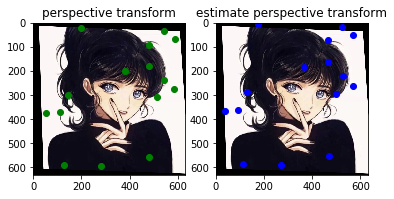

In [301]:
plt.subplot(121)
for p in B:
    u, v = p
    plt.scatter(u, v, c='g')
plt.title("perspective transform")
plt.imshow(img_warp)

plt.subplot(122)
for p in B_hat:
    u, v = p
    plt.scatter(u, v, c='b')
plt.title("estimate perspective transform")
plt.imshow(img_warp)
plt.show()